In [1]:
%cd ..

/Users/peli/Projects/Repositories/DDM-NumEstPark


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import joblib
import pymc as pm
import pytensor.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import graphviz
import seaborn as sns
from datetime import datetime
from src.model import build_subject_model, build_hierarchical, build_hierarchical_with_prior
from src.utils import get_paths

In [3]:
def get_sub_paths():
    """
    Return a list of all file paths of csv data
    """
    dir = "data"
    base = Path.cwd()
    data_dir = base / dir
    data_files = list(data_dir.glob('*.csv'))
    print(f"data_files {data_files}")
    return data_files

def get_subject_data():
    files = get_sub_paths()
    file = files[0]
    df = pd.read_csv(file)
    print(df.head(5))
    subject_df = df[df["S_ID"] == "S_00"]

    x_stim = subject_df["Presented_numerosity"]
    y_obs = subject_df["Estimated_numerosity"]

    print(f"Length n_stim {len(x_stim)}")
    print(f"n_stim: {x_stim.value_counts().sort_index()}")
    print(f"Length y_obs {len(y_obs)}")
    print(f"y_obs: {y_obs.value_counts().sort_index()}")
    return x_stim, y_obs

def get_all_data(
        subset_prop: float | None = None
):
    path = get_paths("dataset", "*")

    df = pd.read_csv(path)
    

    if subset_prop:
        assert 0 < subset_prop < 1
        np.random.seed(89)
        # Get unique subject IDs
        unique_subjects = df["S_ID"].unique()
        # Randomly sample ~20% of subjects
        n_subset = max(1, int(subset_prop * len(unique_subjects)))  # at least 1 subject
        sampled_subjects = np.random.choice(
            unique_subjects, 
            size=n_subset, 
            replace=False
        )
        # Filter dataframe to only those subjects
        df = df[df["S_ID"].isin(sampled_subjects)].reset_index(drop=True)

    X = df
    

    return X



In [4]:
get_all_data(subset_prop=0.5)

data_files [PosixPath('/Users/peli/Projects/Repositories/DDM-NumEstPark/dataset/study2.csv')]
unpacked list


,S_ID,s_param_id_code,Trial,Seed,Delay,Presented_numerosity,Estimated_numerosity,Response_time,Duration_Display,s_param_PD_diagnostic,...,s_param_PD_side,s_duration_PD,s_answer_Q1,s_answer_Q2,s_answer_Q3,s_answer_Q4,s_age,s_gender,entity,dose
0,1,ksj3ywzd-a9be8c96-3894-c782-3ed4-f32ea1449558,41,57,500,5,5,3560,264,PD,...,right,150,0,0,0,0,70,male,object,1000.0
1,1,ksj3ywzd-a9be8c96-3894-c782-3ed4-f32ea1449558,42,58,500,8,10,4211,264,PD,...,right,150,0,0,0,0,70,male,object,1000.0
2,1,ksj3ywzd-a9be8c96-3894-c782-3ed4-f32ea1449558,43,75,500,7,8,2992,265,PD,...,right,150,0,0,0,0,70,male,object,1000.0
3,1,ksj3ywzd-a9be8c96-3894-c782-3ed4-f32ea1449558,44,7,500,6,8,2563,262,PD,...,right,150,0,0,0,0,70,male,object,1000.0
4,1,ksj3ywzd-a9be8c96-3894-c782-3ed4-f32ea1449558,45,34,500,6,7,3167,263,PD,...,right,150,0,0,0,0,70,male,object,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4715,98,pnj1_l0hfm3ak-70368bc1-443e-4796-3be7-e99a8c61...,76,40,500,7,5,4052,257,PD,...,both,258,0,0,0,0,79,female,human,750.0
4716,98,pnj1_l0hfm3ak-70368bc1-443e-4796-3be7-e99a8c61...,77,62,500,8,6,4593,265,PD,...,both,258,0,0,0,0,79,female,human,750.0
4717,98,pnj1_l0hfm3ak-70368bc1-443e-4796-3be7-e99a8c61...,78,28,500,6,6,3361,258,PD,...,both,258,0,0,0,0,79,female,human,750.0
4718,98,pnj1_l0hfm3ak-70368bc1-443e-4796-3be7-e99a8c61...,79,17,500,7,5,4474,256,PD,...,both,258,0,0,0,0,79,female,human,750.0


In [5]:
# Load data
X = get_all_data()

# Encode hallucination group as Categorical (trial-level, but will extract per subject)
X["s_param_ph"] = X["s_param_ph"].replace({"1mh": "3mhch"})
order = ['0nh', '3mhch']
X["s_param_ph"] = pd.Categorical(X["s_param_ph"], categories=order, ordered=True)

# 1. Count UNIQUE subjects per hallucination group
subject_groups = X.drop_duplicates("S_ID")[["S_ID", "s_param_ph"]]
group_counts = subject_groups["s_param_ph"].value_counts().reindex(order, fill_value=0)
print("Number of subjects per hallucination group (s_param_ph):")
print(group_counts)
print()

# Number of unique participants
n_subjects_total = X["S_ID"].nunique()
print(f"Total number of unique subjects: {n_subjects_total}")

# Presented simtuli and estimated stimuli statistics
x_min = X["Presented_numerosity"].min()
x_max = X["Presented_numerosity"].max()
print(f"Presented numerosity Min: {x_min} Max: {x_max}")
y_min = X["Estimated_numerosity"].min()
y_max = X["Estimated_numerosity"].max()
y_mean = X["Estimated_numerosity"].mean()
print(f"Estimated numerosity Min: {y_min} Max: {y_max} Mean: {y_mean}")


data_files [PosixPath('/Users/peli/Projects/Repositories/DDM-NumEstPark/dataset/study2.csv')]
unpacked list
Number of subjects per hallucination group (s_param_ph):
s_param_ph
0nh      55
3mhch    63
Name: count, dtype: int64

Total number of unique subjects: 118
Presented numerosity Min: 5 Max: 8
Estimated numerosity Min: -11 Max: 112 Mean: 7.66207627118644


Outlier:


,S_ID,s_param_id_code,Trial,Seed,Delay,Presented_numerosity,Estimated_numerosity,Response_time,Duration_Display,s_param_PD_diagnostic,...,s_param_PD_side,s_duration_PD,s_answer_Q1,s_answer_Q2,s_answer_Q3,s_answer_Q4,s_age,s_gender,entity,dose
435,110,pnj1_l12fu8xk-801958f3-8a21-c11a-62a3-3dcd041c...,36,30,500,6,101,2120,268,PD,...,left,25,0,0,0,0,71,male,object,100.0
4066,83,pnj1_kyfv4l5x-5728854f-4075-0138-d70f-4a597ec8...,67,36,500,7,77,7884,254,PD,...,left,69,3,1,0,0,64,male,object,140.0
4216,87,pnj1_kza5dut3-000a438f-3562-8a51-5325-0cd55027...,57,58,500,5,55,5480,263,PD,...,left,19,2,3,2,0,68,female,object,100.0
4863,102,pnj1_l0t6nsgp-3ef9fd2f-6dd3-d9aa-658e-fef3b7cf...,64,36,500,7,112,4485,264,PD,...,right,18,1,1,0,0,46,female,human,205.0
4960,106,pnj1_l0znj71y-f31c8945-a09d-bec2-7a11-4781a32a...,41,75,500,8,51,3269,262,PD,...,right,124,1,3,1,1,71,female,human,125.0
6000,141,pnj1_l1nds30a-780cf421-946e-c85e-3d63-6a6f79c9...,41,81,500,7,103,1594,255,PD,...,right,68,2,2,0,0,61,male,human,100.0
6572,161,pnj1_l2stcu21-6fca2552-d7b9-e305-f0f5-db63ede6...,53,19,500,7,112,35757,264,PD,...,unkn0wn,130,2,2,2,1,72,male,human,0.0


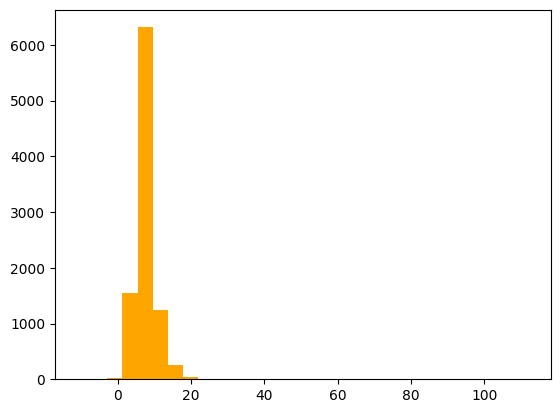

In [ ]:
# identified some outliers that might be neccesary to deal with
# plot histogram of 
plt.hist(X["Estimated_numerosity"], bins=30, color="orange")

# identify outlier rows
outliers = X[X["Estimated_numerosity"] > 50]
print("Outlier:")
outliers

# TODO: Filter out these weird outliers

Remaining rows: 9361


(array([1.488e+03, 3.715e+03, 1.665e+03, 1.610e+03, 1.800e+02, 3.960e+02,
        8.400e+01, 1.600e+02, 6.000e+00, 3.400e+01, 1.000e+01, 5.000e+00,
        2.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([ 4.        ,  5.53333333,  7.06666667,  8.6       , 10.13333333,
        11.66666667, 13.2       , 14.73333333, 16.26666667, 17.8       ,
        19.33333333, 20.86666667, 22.4       , 23.93333333, 25.46666667,
        27.        , 28.53333333, 30.06666667, 31.6       , 33.13333333,
        34.66666667, 36.2       , 37.73333333, 39.26666667, 40.8       ,
        42.33333333, 43.86666667, 45.4       , 46.93333333, 48.46666667,
        50.        ]),
 <BarContainer object of 30 artists>)

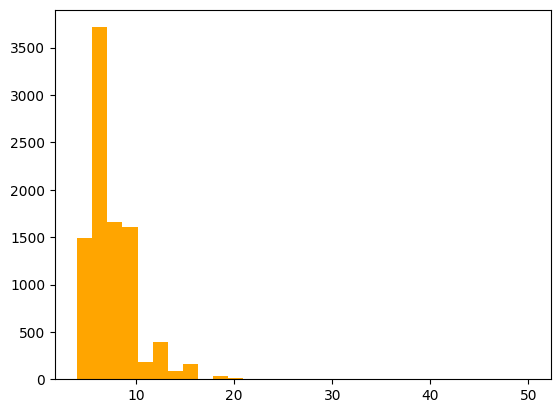

In [16]:

# remove rows where Estimated_numerosity > 24
X = X[X["Estimated_numerosity"].between(4, 50)].copy()

# optional: check result
print(f"Remaining rows: {len(X)}")
plt.hist(X["Estimated_numerosity"], bins=30, color="orange")

In [8]:

# Encode entity (trial-level)
entity, entity_labels = pd.factorize(X["entity"])  # shape (n_trials,)
print(entity)

# Extract trial-level numerosity
x_stim = X["Presented_numerosity"].values
y_obs = X["Estimated_numerosity"].values
dose = X["dose"].values

# --- Build subject-level mapping ---
subject_info = X.drop_duplicates("S_ID").sort_values("S_ID")

# Map original S_ID → 0-based integer index (for PyMC)
subject_id_map = {subj: idx for idx, subj in enumerate(subject_info["S_ID"])}
subject_id = X["S_ID"].map(subject_id_map).values.astype(int)  # shape (n_trials,) → ✅ REPEATS ARE OK

# ✅ CORRECT: extract integer group codes at SUBJECT level
ph_type = subject_info["s_param_ph"].cat.codes.values  # shape (n_subjects,), dtype=int

# Optional: sanity checks
assert len(ph_type) == len(subject_info), "Group codes must be per subject"
assert subject_id.max() == len(ph_type) - 1, "subject_id must align with group codes"
assert set(np.unique(ph_type)) <= {0, 1, 2}, "Invalid group codes"

print(f"subject_id {len(subject_id)}")
print(f"ph_type {len(ph_type)}")

[0 0 0 ... 1 1 1]
subject_id 9432
ph_type 118


In [9]:
print(f"Building model ...")
model = build_hierarchical_with_prior(
    x_stim,
    y_obs,
    subject_id,
    ph_type,
    entity
)


Building model ...


In [10]:

sample_config = {
    "draws": 2000,
    "tune": 2000,
    "target_accept": 0.9,
    "chains": 4
}

# Sampling
with model:
    prior_pred = pm.sample_prior_predictive(
        samples=5000,
        var_names=["y_pp", "y_pred_pp"]
    )

    trace = pm.sample(**sample_config)

    post_pred = pm.sample_posterior_predictive(trace, var_names=["y_latent", "y_pred"])

/var/folders/38/7bfzlz1n56s9bgpgqxr75fzh0000gn/T/ipykernel_40011/3418453520.py:10: UserWarning:

The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.

Sampling: [gamma_group_entity, gamma_subj_entity, log_alpha_group, log_alpha_subj, phi, w_group, w_subj, y_pp]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_group, w_subj, gamma_group_entity, gamma_subj_entity, log_alpha_group, log_alpha_subj, phi, y_pp, y_latent]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 734 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/38/7bfzlz1n56s9bgpgqxr75fzh0000gn/T/ipykernel_40011/3418453520.py:17: UserWarning:

The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.

Sampling: [y_latent]


Output()

In [14]:
trace.extend(prior_pred)
trace.extend(post_pred)
idata = trace
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> constant_data

In [15]:
# TODO: save idata object hereø

## Prior Predictive


In [16]:
y_obs

array([ 5, 10,  8, ...,  6,  8,  8], shape=(9432,))

(47160000,)
(9432,)
Observed range: 0 to 50
Prior Predictive range: -32.73895347009852 to 81.59814915490348
Prior Predictive median: 6.247462353901722


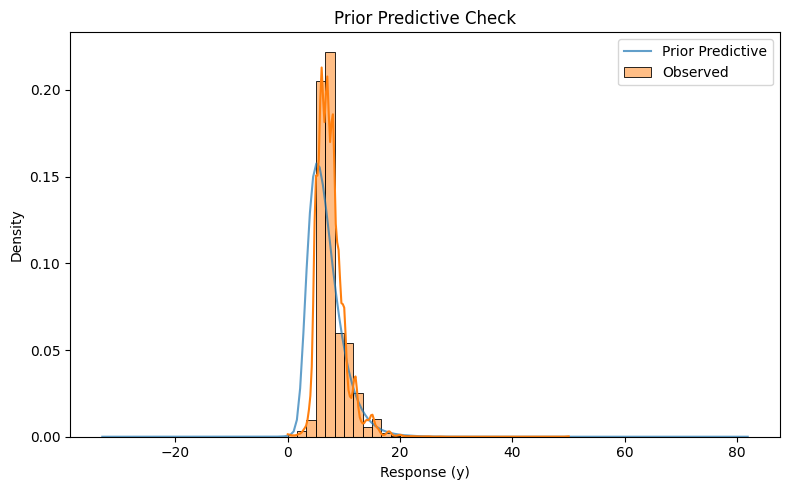

In [19]:
pc = prior_pred.prior.y_pp.values.flatten() # shape (1,5000,880), chain,samples,trials
pc_pred = prior_pred.prior.y_pred_pp.values.flatten() # shape (1,5000,880), chain,samples,trials

print(pc.shape)
print(y_obs.shape)

print(f"Observed range: {y_obs.min()} to {y_obs.max()}")
print(f"Prior Predictive range: {pc.min()} to {pc.max()}")
print(f"Prior Predictive median: {np.median(pc)}")

# Plot
plt.figure(figsize=(8, 5))
sns.kdeplot(pc, label="Prior Predictive", alpha=0.7)
sns.histplot(y_obs, kde=True, stat="density", 
             label="Observed", alpha=0.5, color="C1", bins=30)

plt.xlabel("Response (y)")
plt.ylabel("Density")
plt.title("Prior Predictive Check")
plt.legend()
plt.tight_layout()
plt.show()

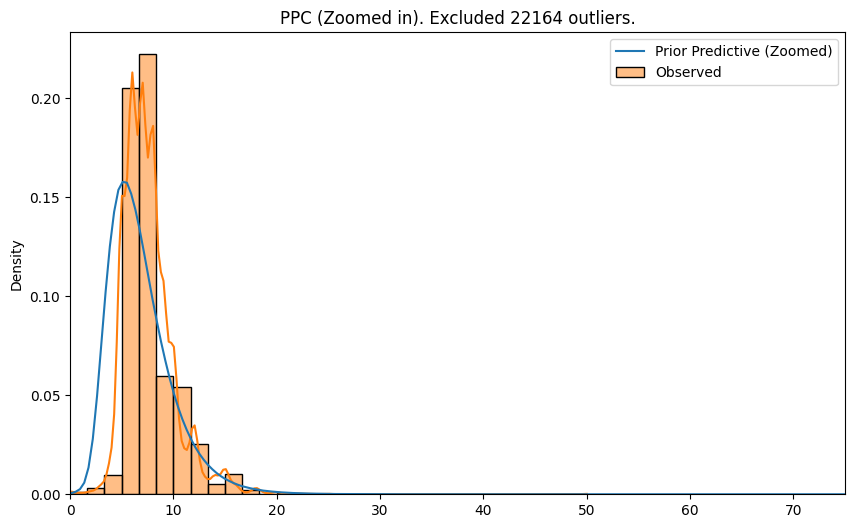

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# 1. Plot Observed
sns.histplot(y_obs, kde=True, stat="density", label="Observed", color="C1", bins=30)

# 2. Plot Prior Predictive (Clipped)
# We filter the data just for plotting so the KDE doesn't explode
pc_clipped = pc[(pc >= 0) & (pc <= y_obs.max() * 2)] 

sns.kdeplot(pc_clipped, label="Prior Predictive (Zoomed)", color="C0")

plt.xlim(0, y_obs.max() * 1.5) # Force the view to relevant area
plt.title(f"PPC (Zoomed in). Excluded {len(pc) - len(pc_clipped)} outliers.")
plt.legend()
plt.show()

## Convergence & Sampling Diagnostics

In [21]:
az.style.use("arviz-whitegrid")

In [ ]:

# Basic diagnostics
summary = az.summary(idata, var_names=["w_group", "gamma_group_entity", "log_alpha_group_entity", "phi"], round_to=2)

print(summary)

                                mean    sd  hdi_3%  hdi_97%  mcse_mean  \
w_group[NH]                     0.20  0.02    0.16     0.23       0.00   
w_group[PH]                     0.18  0.02    0.15     0.21       0.00   
gamma_group_entity[NH, object]  1.26  0.22    0.84     1.66       0.01   
gamma_group_entity[NH, human]  -0.99  0.19   -1.35    -0.62       0.01   
gamma_group_entity[PH, object]  1.12  0.31    0.57     1.71       0.02   
gamma_group_entity[PH, human]  -1.83  0.25   -2.30    -1.38       0.02   
log_alpha_group[NH]             0.11  0.03    0.06     0.17       0.00   
log_alpha_group[PH]             0.14  0.03    0.08     0.20       0.00   
phi[NH]                         0.01  0.01    0.00     0.03       0.00   
phi[PH]                         0.01  0.01    0.00     0.03       0.00   

                                mcse_sd  ess_bulk  ess_tail  r_hat  
w_group[NH]                        0.00  14727.06   5528.51   1.00  
w_group[PH]                        0.00  15170.

array([[<Axes: title={'center': 'w_group'}>,
        <Axes: title={'center': 'w_group'}>],
       [<Axes: title={'center': 'gamma_group_entity'}>,
        <Axes: title={'center': 'gamma_group_entity'}>],
       [<Axes: title={'center': 'log_alpha_group'}>,
        <Axes: title={'center': 'log_alpha_group'}>],
       [<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>]],
      dtype=object)

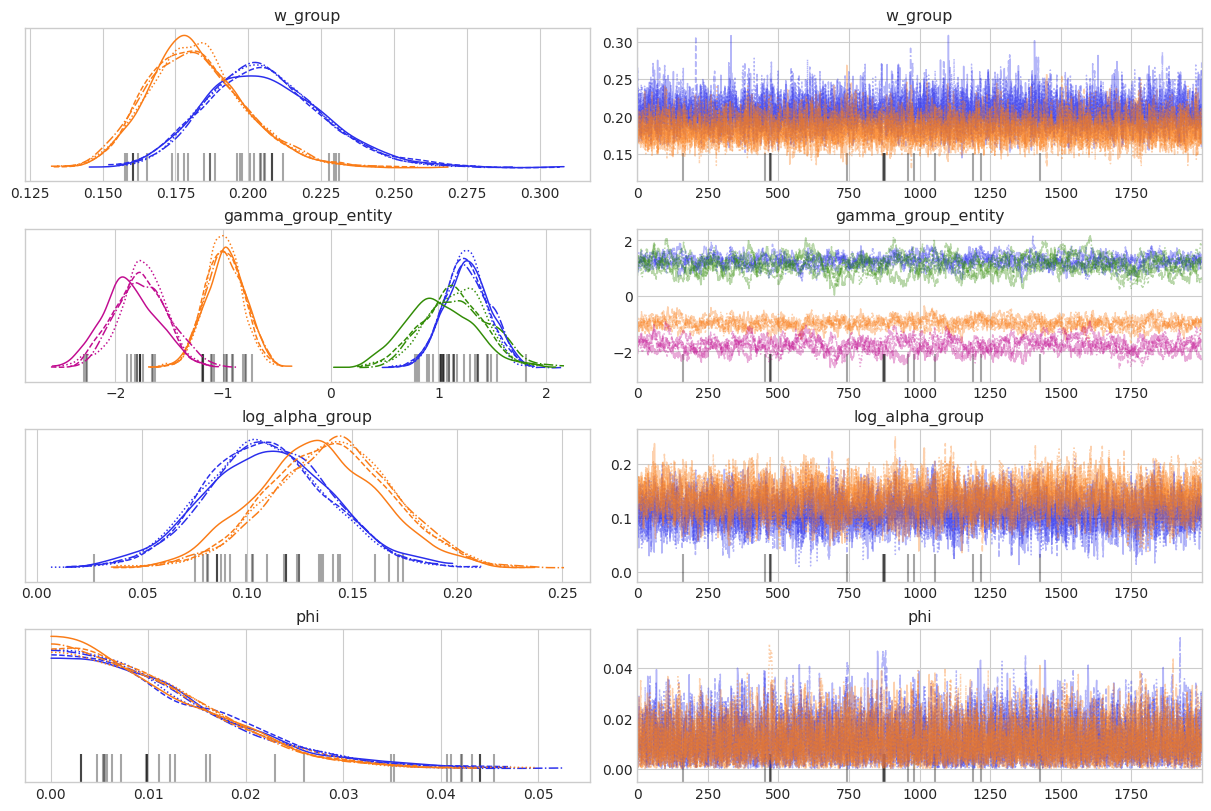

In [20]:
# Trace plots
az.plot_trace(idata, var_names=["w_group", "gamma_group_entity", "log_alpha_group", "phi"])

## Posterior Predictive

(47165000,)
(9433,)


/var/folders/38/7bfzlz1n56s9bgpgqxr75fzh0000gn/T/ipykernel_35591/855501415.py:16: UserWarning:

The figure layout has changed to tight



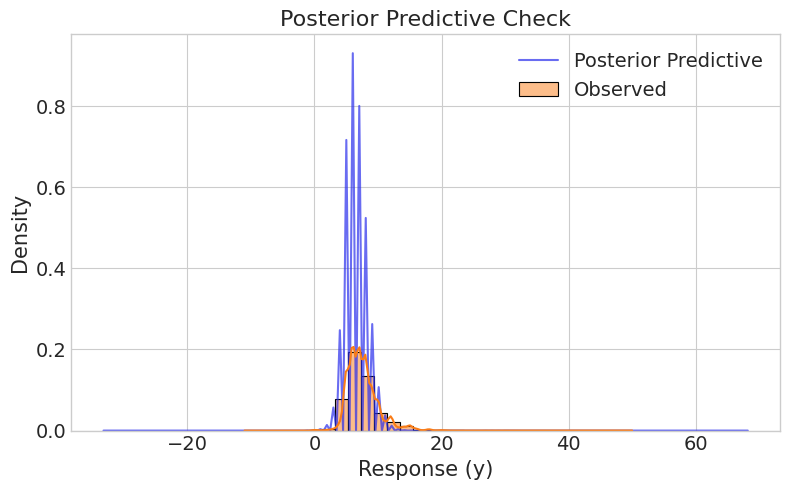

In [21]:
ppc = idata.posterior_predictive.y_pred.values # shape (4,2000,880), chain,samples,trials
ppc = ppc.flatten()
print(pc.shape)
print(y_obs.shape)

# Plot
plt.figure(figsize=(8, 5))
sns.kdeplot(ppc, label="Posterior Predictive", alpha=0.7, color="C0")
sns.histplot(y_obs, kde=True, stat="density", 
             label="Observed", alpha=0.5, color="C1", bins=30)

plt.xlabel("Response (y)")
plt.ylabel("Density")
plt.title("Posterior Predictive Check")
plt.legend()
plt.tight_layout()
plt.show()

## Posterior Summaries of Key Group Parameters


In [ ]:
az.plot_forest(
    idata,
    var_names=["w_group", "gamma_group_entity", "log_alpha_group", "phi"],
    combined=True,
    hdi_prob=0.95
)

In [23]:
# Group-level bias in scaling (alpha)
alpha_summary = az.summary(idata, var_names=["log_alpha_prior_group_mu"], round_to=3)
print(alpha_summary)

# Group-level compression (beta)
beta_summary = az.summary(idata, var_names=["beta_group_mu"], round_to=3)
print(beta_summary)

# Human vs. object modulation
delta_alpha_summary = az.summary(idata, var_names=["delta_log_alpha_prior"], round_to=3)
print(delta_alpha_summary)

delta_beta_summary = az.summary(idata, var_names=["delta_beta_group_entity"], round_to=3)
print(delta_beta_summary)


KeyError: 'var names: "[\'log_alpha_prior_group_mu\'] are not present" in dataset'

Noise summaries

In [35]:
az.summary(idata, var_names=["sigma_0", "sigma_1"], round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_0,0.017,0.017,0.000,0.047,0.0,0.0,7606.962,4780.502,1.000
sigma_1,0.469,0.006,0.459,0.480,0.0,0.0,2385.982,3885.660,1.002


## Test Albert et al. Hypothesis: Group × Entity Interaction

In [19]:

# 1. Define the N you want to test (e.g., 8 items)
N_tests = range(0,10)

for N_test in N_tests:

    post = idata.posterior

    # 2. Extract Base Parameters
    alpha_mu = post["alpha_group_mu"]
    beta_mu = post["beta_group_mu"]

    # 3. Extract Interaction Parameters (Select specific Groups and Entities)
    # Note: Ensure you use the exact variable names from your trace
    delta_alpha = post["delta_alpha_group_entity"]
    delta_beta = post["delta_beta_group_entity"]

    # --- Calculate Net Parameters for STRONG Group (Human) ---
    # alpha_net = Group Mean + Group-Specific Human Adjustment
    alpha_strong_human = alpha_mu.sel(group="PH") + delta_alpha.sel(group="PH", entity_type="human")
    beta_strong_human  = beta_mu.sel(group="PH") + delta_beta.sel(group="PH", entity_type="human")

    # --- Calculate Net Parameters for NO Group (Human) ---
    alpha_no_human = alpha_mu.sel(group="NH") + delta_alpha.sel(group="NH", entity_type="human")
    beta_no_human  = beta_mu.sel(group="NH") + delta_beta.sel(group="NH", entity_type="human")

    # --- 4. CALCULATE THE ACTUAL ESTIMATES (Psychophysics) ---
    # Prediction = alpha * (N ** beta)
    pred_strong_human = alpha_strong_human * (N_test ** beta_strong_human)
    pred_no_human     = alpha_no_human * (N_test ** beta_no_human)

    # --- 5. Compare the Estimates ---
    # "Do Strong Hallucinators see MORE humans than Non-Hallucinators?"
    diff_perception = pred_strong_human - pred_no_human
    prob_hypothesis = (diff_perception > 0).mean().item()

    print(f"At N={N_test}:")
    print(f"Mean Est Strong: {pred_strong_human.mean().item():.2f}")
    print(f"Mean Est No:     {pred_no_human.mean().item():.2f}")
    print(f"Probability that PH > NH: {prob_hypothesis:.3f}")
    print(f"\n")

At N=0:
Mean Est Strong: 0.00
Mean Est No:     0.00
Probability that PH > NH: 0.000


At N=1:
Mean Est Strong: 0.74
Mean Est No:     1.21
Probability that PH > NH: 0.000


At N=2:
Mean Est Strong: 1.87
Mean Est No:     2.39
Probability that PH > NH: 0.005


At N=3:
Mean Est Strong: 3.22
Mean Est No:     3.56
Probability that PH > NH: 0.077


At N=4:
Mean Est Strong: 4.72
Mean Est No:     4.73
Probability that PH > NH: 0.484


At N=5:
Mean Est Strong: 6.37
Mean Est No:     5.90
Probability that PH > NH: 0.928


At N=6:
Mean Est Strong: 8.13
Mean Est No:     7.06
Probability that PH > NH: 0.995


At N=7:
Mean Est Strong: 10.00
Mean Est No:     8.22
Probability that PH > NH: 1.000


At N=8:
Mean Est Strong: 11.96
Mean Est No:     9.38
Probability that PH > NH: 1.000


At N=9:
Mean Est Strong: 14.00
Mean Est No:     10.54
Probability that PH > NH: 1.000




A theoretical investigation based on summary mean values into the overestimation of human numerosity in parkinsons patients.

In [31]:
alpha_summary = az.summary(idata, var_names=["alpha_group_mu"], round_to=3)
alpha_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_group_mu[NH],1.195,0.147,0.931,1.478,0.008,0.004,329.256,825.843,1.013
alpha_group_mu[PH],1.045,0.149,0.755,1.316,0.011,0.005,174.026,493.884,1.005


In [30]:
az.summary(idata, var_names=["delta_alpha_group_entity", "delta_beta_group_entity"], round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"delta_alpha_group_entity[NH, object]",0.072,0.149,-0.201,0.356,0.005,0.002,776.968,1644.381,1.003
"delta_alpha_group_entity[NH, human]",0.014,0.146,-0.265,0.280,0.005,0.002,733.567,1937.845,1.004
"delta_alpha_group_entity[PH, object]",0.303,0.146,0.037,0.583,0.007,0.002,391.544,1465.388,1.002
"delta_alpha_group_entity[PH, human]",-0.305,0.141,-0.562,-0.037,0.009,0.004,220.145,807.450,1.004
"delta_beta_group_entity[NH, object]",-0.063,0.075,-0.201,0.082,0.003,0.002,510.414,1098.521,1.007
"delta_beta_group_entity[NH, human]",0.045,0.074,-0.095,0.181,0.003,0.002,548.114,1250.571,1.007
"delta_beta_group_entity[PH, object]",-0.200,0.074,-0.338,-0.061,0.004,0.002,339.731,953.557,1.009
"delta_beta_group_entity[PH, human]",0.238,0.075,0.097,0.379,0.004,0.002,295.830,913.624,1.009


/var/folders/38/7bfzlz1n56s9bgpgqxr75fzh0000gn/T/ipykernel_36903/3500875230.py:124: UserWarning:

The figure layout has changed to tight



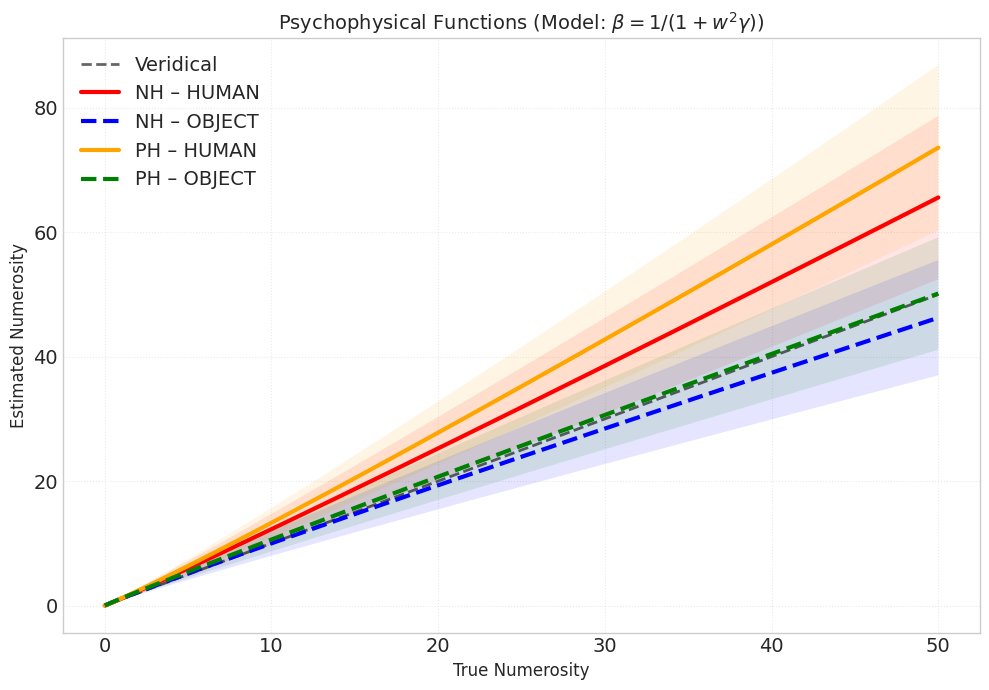

In [26]:
# --- Group Level Parameters (w, phi, log_alpha) ---
w_nh = summary["mean"]["w_group[NH]"]
w_ph = summary["mean"]["w_group[PH]"]

phi_nh = summary["mean"]["phi[NH]"]
phi_ph = summary["mean"]["phi[PH]"]

# Assuming alpha is stored as log_alpha in the trace
log_alpha_nh = summary["mean"]["log_alpha_group[NH]"]
log_alpha_ph = summary["mean"]["log_alpha_group[PH]"]

# --- Entity Level Parameters (gamma) ---
gamma_nh_h = summary["mean"]["gamma_group_entity[NH, human]"]
gamma_nh_o = summary["mean"]["gamma_group_entity[NH, object]"]
gamma_ph_h = summary["mean"]["gamma_group_entity[PH, human]"]
gamma_ph_o = summary["mean"]["gamma_group_entity[PH, object]"]

# Organize for easy access
params_group = {
    "NH": {"w": w_nh, "phi": phi_nh, "log_alpha": log_alpha_nh},
    "PH": {"w": w_ph, "phi": phi_ph, "log_alpha": log_alpha_ph},
}

params_gamma = {
    "NH": {"human": gamma_nh_h, "object": gamma_nh_o},
    "PH": {"human": gamma_ph_h, "object": gamma_ph_o},
}

# -------------------------
# Define Functions
# -------------------------

def get_beta(w, gamma):
    """
    Beta calculation based on model definition:
    beta = 1 / ( 1 + (w^2) * gamma )
    """
    return 1 / (1 + (w**2) * gamma)

def psychophysical_curve(n, alpha, beta):
    """
    Power law mean estimation
    """
    return alpha * (n ** beta)

def calculate_sigma(mu_hat, w, phi):
    """
    Noise calculation based on model definition:
    total_weber = sqrt(w^2 + phi^2)
    sigma = total_weber * mu_hat
    """
    total_weber = np.sqrt(w**2 + phi**2)
    # Ensure sigma is at least a tiny amount (1e-4) akin to the model code
    sigma = np.maximum(total_weber * mu_hat, 1e-4)
    return sigma

# -------------------------
# Setup Data & Plotting
# -------------------------
n_range = np.linspace(0, 50, 200)

plt.figure(figsize=(10, 7))

# Veridical reference
plt.plot(n_range, n_range, "k--", linewidth=2, label="Veridical", alpha=0.6)

colors = {
    ("NH", "human"): "red",
    ("NH", "object"): "blue",
    ("PH", "human"): "orange",
    ("PH", "object"): "green",
}

linestyles = {
    "human": "-",
    "object": "--",
}

for group in ["NH", "PH"]:
    # Retrieve Group Params
    w = params_group[group]["w"]
    phi = params_group[group]["phi"]
    
    # Convert log_alpha back to alpha
    alpha = np.exp(params_group[group]["log_alpha"])
    
    for entity in ["human", "object"]:
        # 1. Calculate Beta
        gamma = params_gamma[group][entity]
        beta = get_beta(w, gamma)
        
        # 2. Calculate Mean Curve (y / mu_hat)
        y = psychophysical_curve(n_range, alpha, beta)
        
        # 3. Calculate Sigma (Dependent on y, w, and phi)
        # Note: In this model, variance scales with the magnitude of the estimate (Scalar Variability)
        sigma_vec = calculate_sigma(y, w, phi)
        
        # 4. Plot Mean Line
        plt.plot(
            n_range,
            y,
            color=colors[(group, entity)],
            linestyle=linestyles[entity],
            linewidth=3,
            label=f"{group} – {entity.upper()}",
        )
        
        # 5. Add Variance Bands
        plt.fill_between(
            n_range, 
            y - sigma_vec, # Lower bound
            y + sigma_vec, # Upper bound
            color=colors[(group, entity)], 
            alpha=0.1,     # Slightly higher alpha to see the bands better
            edgecolor=None
        )

plt.xlabel("True Numerosity", fontsize=12)
plt.ylabel("Estimated Numerosity", fontsize=12)
plt.title("Psychophysical Functions (Model: $\\beta = 1/(1+w^2\\gamma)$)", fontsize=14)
plt.legend(loc="upper left")
plt.grid(True, linestyle=":", alpha=0.4)
plt.tight_layout()
plt.show()

/var/folders/38/7bfzlz1n56s9bgpgqxr75fzh0000gn/T/ipykernel_12593/3574615324.py:46: UserWarning:

The figure layout has changed to tight



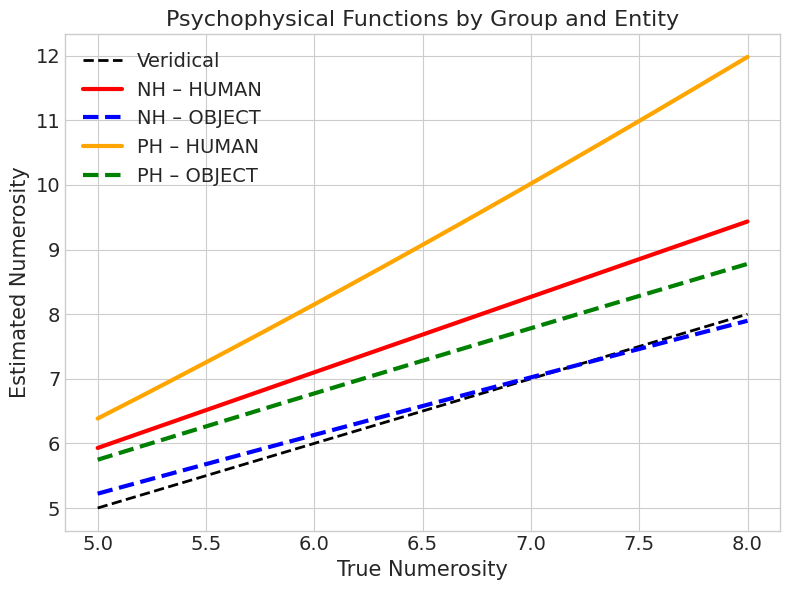

/var/folders/38/7bfzlz1n56s9bgpgqxr75fzh0000gn/T/ipykernel_12593/1942915363.py:23: UserWarning:

The figure layout has changed to tight



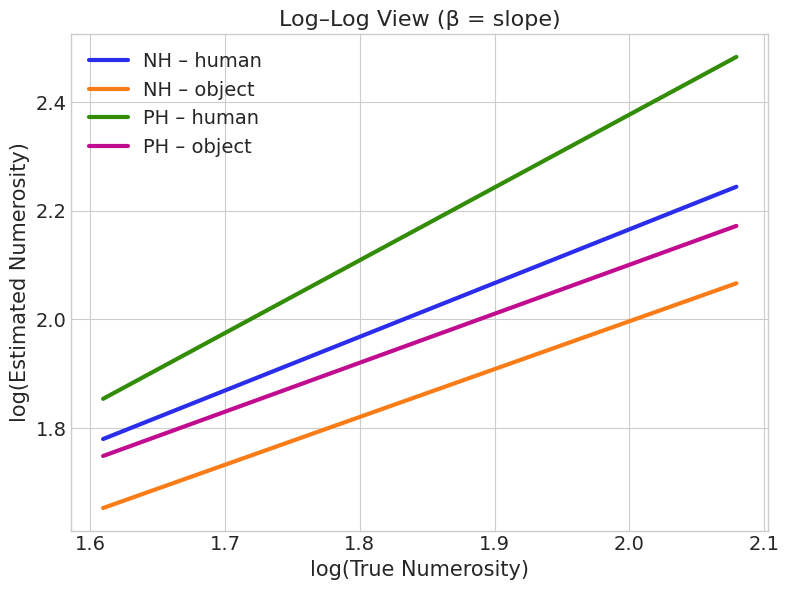

In [34]:
plt.figure(figsize=(8, 6))

for group in ["NH", "PH"]:
    for entity in ["human", "object"]:
        y = psychophysical_curve(
            n_range,
            params_base[group]["alpha"],
            params_base[group]["beta"],
            delta_params[group][entity]["alpha"],
            delta_params[group][entity]["beta"],
        )
        plt.plot(
            np.log(n_range),
            np.log(y),
            linewidth=3,
            label=f"{group} – {entity}",
        )

plt.xlabel("log(True Numerosity)")
plt.ylabel("log(Estimated Numerosity)")
plt.title("Log–Log View (β = slope)")
plt.legend()
plt.tight_layout()
plt.show()


Detected entity labels: ['object' 'human']


/var/folders/38/7bfzlz1n56s9bgpgqxr75fzh0000gn/T/ipykernel_12593/3334890079.py:96: UserWarning:

The figure layout has changed to tight



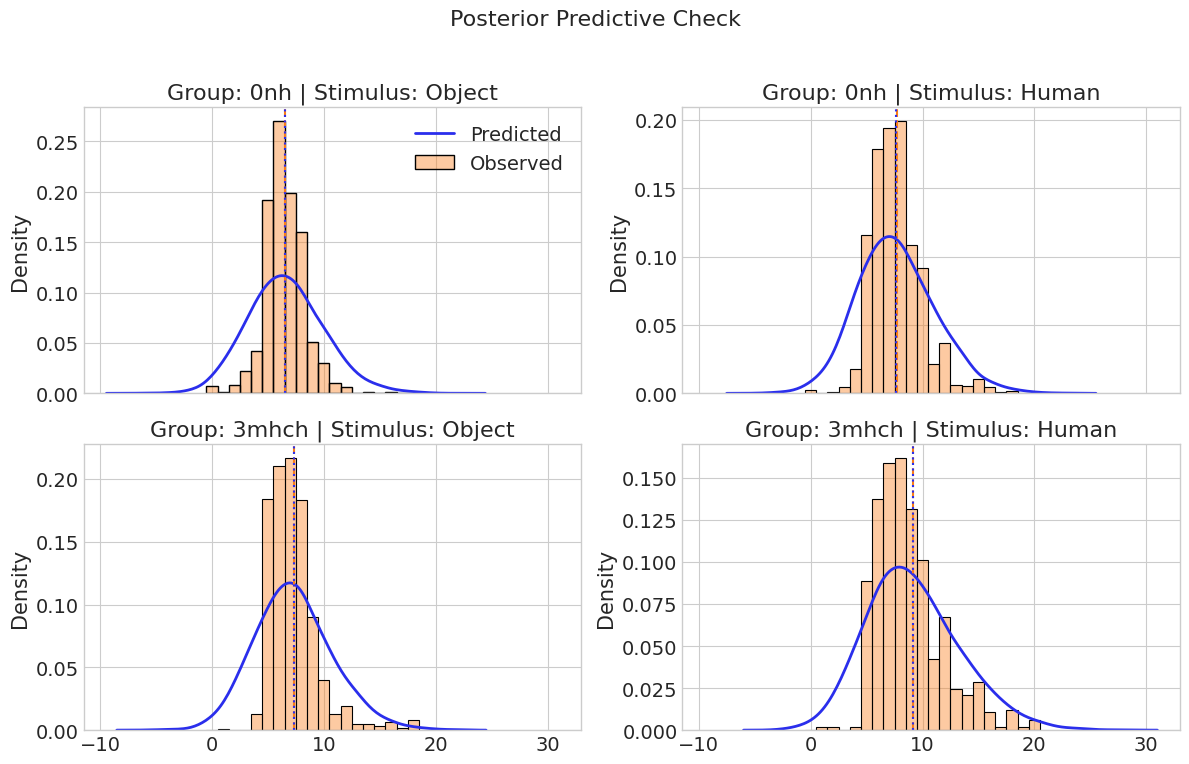

In [24]:
# --- 1. PREPARE MAPPING ---
# Detect what string/value corresponds to "Human" vs "Object" in your DataFrame
# Adjust these strings if your print output above shows something different (e.g. 'Human' vs 'human')
unique_entities = X["entity"].unique()
print(f"Detected entity labels: {unique_entities}")

# Create a mapping for the loop. 
# We assume the model treated 0=Object, 1=Human. 
# We need to know which string in X corresponds to which integer.
# commonly:
if "human" in unique_entities or "Human" in unique_entities:
    # Dictionary mapping: {Model_Int: DataFrame_Value}
    # Adjust the dictionary values based on your debug print!
    entity_map = {
        0: "object",  # or "Object"
        1: "human"    # or "Human"
    }
else:
    # If they are already integers 0 and 1
    entity_map = {0: 0, 1: 1}

# Flatten predictions
y_pred_all = idata.posterior_predictive.y_pred.values
n_chains, n_draws, n_trials = y_pred_all.shape
y_pred_flat = y_pred_all.reshape(n_chains * n_draws, n_trials)

# Ensure groups are sorted consistently
groups = sorted(X["s_param_ph"].unique())

# --- 2. PLOT ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=False)
fig.suptitle("Posterior Predictive Check", fontsize=16)

color_pred = "C0"  # Blue
color_obs = "C1"   # Orange

for i, group in enumerate(groups):
    for j, ent_int in enumerate([0, 1]): # Loop over model integers
        ax = axes[i, j]
        
        # Get the actual value used in the dataframe
        df_ent_value = entity_map[ent_int]
        
        # Create Mask using the DataFrame value
        mask = (X["s_param_ph"] == group) & (X["entity"] == df_ent_value)
        
        # Debugging check inside loop
        if mask.sum() == 0:
            ax.text(0.5, 0.5, f"NO DATA\nGroup: {group}\nEntity: {df_ent_value}", 
                    ha='center', va='center', color='red')
            continue
            
        # Get Data
        # Ensure y_obs is a numpy array aligned with X
        # If y_obs is a Series, use y_obs.values[mask]
        obs_subset = y_obs[mask] if isinstance(y_obs, np.ndarray) else y_obs.values[mask]
        
        pred_subset = y_pred_flat[:, mask]
        pred_subset_flat = pred_subset.flatten()
        
        # Plot Observed
        sns.histplot(
            obs_subset, 
            stat="density", 
            bins=np.arange(0, 22) - 0.5, 
            color=color_obs, 
            alpha=0.4, 
            label="Observed", 
            ax=ax
        )
        
        # Plot Predicted (Subsampled for speed)
        plot_sample_size = min(len(pred_subset_flat), 10000)
        rng = np.random.default_rng(42)
        subset_for_kde = rng.choice(pred_subset_flat, size=plot_sample_size, replace=False)
        
        sns.kdeplot(
            subset_for_kde, 
            color=color_pred, 
            linewidth=2, 
            label="Predicted", 
            ax=ax,
            bw_adjust=1.5
        )
        
        # Labels
        ent_label = "Human" if ent_int == 1 else "Object"
        group_label = str(group)
        ax.set_title(f"Group: {group_label} | Stimulus: {ent_label}")
        
        # Mean lines
        ax.axvline(np.mean(obs_subset), color=color_obs, linestyle="--")
        ax.axvline(np.mean(pred_subset_flat), color=color_pred, linestyle=":")

axes[0,0].legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Entity-Specific Effects

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

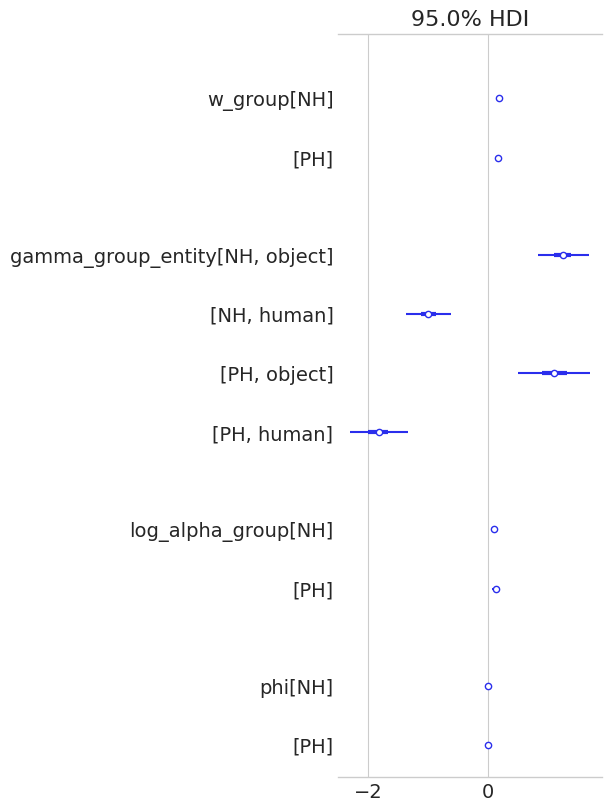

In [24]:
az.plot_forest(
    idata,
    var_names=["w_group", "gamma_group_entity", "log_alpha_group", "phi"],
    combined=True,
    hdi_prob=0.95
)

# Subject level parameters